In [1]:
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import optuna
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
df = pd.read_csv(r"C:\Users\USER\Documents\Tradingstuff\IV_PI_Stratdf_for_training.csv")
df.set_index('Unnamed: 0',inplace=True)
df

,high,low,close_price,volume,log_return,smoothed_IV,min_max_PI,rolling_std_30,rolling_annual_vol_30,Vol_Spread,...,long_RSI,RSI_diff,MACD_Line,MACD_Signal,MACD_Histogram,Vol_Spread_ROC,Vol_Spread_RSI,Vol_Spread_MACD,Vol_Spread_Signal,Vol_Spread_MACD_Hist
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2023-07-30 14:00:00,29391.82,29381.13,29391.81,33.27224,0.003541,35.33,-0.000273,0.002939,27.505899,7.824101,...,51.711811,-22.383681,1.951589,-2.217337,4.168926,0.270454,78.532975,0.479000,0.310619,0.168381
2023-07-30 15:00:00,29349.37,29349.36,29349.37,5.54135,-0.001445,35.24,-0.000876,0.002939,27.508929,7.731071,...,47.436856,-14.262119,4.338682,-0.906133,5.244815,0.248834,75.729101,0.546664,0.357828,0.188836
2023-07-30 16:00:00,29385.67,29375.99,29380.02,39.36677,0.001044,35.76,-0.000683,0.002910,27.239903,8.520097,...,50.755406,-18.931974,8.604481,0.995990,7.608492,0.422478,79.527923,0.656389,0.417540,0.238849
2023-07-30 17:00:00,29396.52,29396.51,29396.52,1.47595,0.000561,35.82,-0.000651,0.002910,27.232957,8.587043,...,54.086696,-17.382354,13.164815,3.429755,9.735060,0.409577,80.409140,0.740217,0.482076,0.258141
2023-07-30 18:00:00,29356.00,29354.99,29355.99,5.72125,-0.001380,35.79,-0.000752,0.002908,27.215382,8.574618,...,54.941333,-2.553402,13.354536,5.414711,7.939825,0.419616,83.735404,0.796467,0.544954,0.251513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-08 08:00:00,86112.50,86070.77,86071.57,10.03545,-0.001458,52.12,-0.000815,0.006723,62.928420,-10.808420,...,41.538452,-7.389541,-665.638390,-645.015626,-20.622764,0.286658,0.000000,-1.549088,-1.453640,-0.095447
2025-03-08 09:00:00,85943.29,85889.54,85943.28,5.34728,-0.001492,52.04,-0.000826,0.006721,62.904620,-10.864620,...,40.333841,-2.528123,-663.997329,-648.811967,-15.185362,0.268106,0.000000,-1.561960,-1.475304,-0.086656
2025-03-08 10:00:00,86140.51,86121.91,86123.19,2.67768,0.002091,51.89,-0.000839,0.006720,62.892348,-11.002348,...,41.500236,-14.964508,-640.792881,-647.208150,6.415268,0.238633,0.000000,-1.565233,-1.493290,-0.071943


In [3]:
df = df.loc['2023-07-29':'2025-01-01']
df

,high,low,close_price,volume,log_return,smoothed_IV,min_max_PI,rolling_std_30,rolling_annual_vol_30,Vol_Spread,...,long_RSI,RSI_diff,MACD_Line,MACD_Signal,MACD_Histogram,Vol_Spread_ROC,Vol_Spread_RSI,Vol_Spread_MACD,Vol_Spread_Signal,Vol_Spread_MACD_Hist
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2023-07-30 14:00:00,29391.82,29381.13,29391.81,33.27224,0.003541,35.33,-0.000273,0.002939,27.505899,7.824101,...,51.711811,-22.383681,1.951589,-2.217337,4.168926,0.270454,78.532975,0.479000,0.310619,0.168381
2023-07-30 15:00:00,29349.37,29349.36,29349.37,5.54135,-0.001445,35.24,-0.000876,0.002939,27.508929,7.731071,...,47.436856,-14.262119,4.338682,-0.906133,5.244815,0.248834,75.729101,0.546664,0.357828,0.188836
2023-07-30 16:00:00,29385.67,29375.99,29380.02,39.36677,0.001044,35.76,-0.000683,0.002910,27.239903,8.520097,...,50.755406,-18.931974,8.604481,0.995990,7.608492,0.422478,79.527923,0.656389,0.417540,0.238849
2023-07-30 17:00:00,29396.52,29396.51,29396.52,1.47595,0.000561,35.82,-0.000651,0.002910,27.232957,8.587043,...,54.086696,-17.382354,13.164815,3.429755,9.735060,0.409577,80.409140,0.740217,0.482076,0.258141
2023-07-30 18:00:00,29356.00,29354.99,29355.99,5.72125,-0.001380,35.79,-0.000752,0.002908,27.215382,8.574618,...,54.941333,-2.553402,13.354536,5.414711,7.939825,0.419616,83.735404,0.796467,0.544954,0.251513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,94166.89,94121.21,94166.88,3.23660,0.003097,60.70,-0.000598,0.005941,55.608099,5.091901,...,51.122095,6.888466,324.475675,298.801123,25.674552,-0.075915,46.169825,-0.083437,-0.058514,-0.024924
2024-12-31 20:00:00,93656.80,93518.85,93564.04,49.22096,-0.006422,60.56,-0.000291,0.005946,55.651962,4.908038,...,48.878121,35.139494,242.400013,287.520901,-45.120888,-0.138107,44.516507,-0.125631,-0.071937,-0.053694
2024-12-31 21:00:00,93940.00,93864.51,93899.68,6.65119,0.003581,60.60,-0.000441,0.005942,55.614205,4.985795,...,50.357832,29.691664,202.108027,270.438326,-68.330299,-0.121167,42.767988,-0.151055,-0.087761,-0.063294


In [4]:
'''target_columns = ['label_14', 'label_15', 'label_16', 'label_17', 'label_18', 'label_19']

# Define feature columns as all columns that are not the target columns
feature_columns = [col for col in df.columns if col not in target_columns]
X = df[feature_columns]'''

"target_columns = ['label_14', 'label_15', 'label_16', 'label_17', 'label_18', 'label_19']\n\n# Define feature columns as all columns that are not the target columns\nfeature_columns = [col for col in df.columns if col not in target_columns]\nX = df[feature_columns]"

In [5]:
'''# Dictionaries to store best parameters and models for each target
best_params_dict = {}
best_models = {}
from sklearn.metrics import log_loss
for target in target_columns:
    print(f"\nTuning target: {target}")
    y = df[target]
    # Ensure your labels are mapped appropriately (e.g., -1->0, 0->1, 1->2) if needed.
    y = y.map({-1: 0, 0: 1, 1: 2})
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 400),
            'max_depth': trial.suggest_int('max_depth', 3, 5),
            'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1, log=True),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
            'subsample': trial.suggest_float('subsample', 0.3, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 2, log=True),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 2, log=True),
            'gamma': trial.suggest_float('gamma', 0.1, 2, log=True),
            # Fixed parameters for multi-class classification:
            'objective': 'multi:softprob',
            'num_class': 3,
            'tree_method': 'hist',   # efficient histogram-based algorithm
            'device': 'cuda',        # use GPU acceleration if available
            'early_stopping_rounds': 100
        }
        
        # Prepare out-of-fold predictions array (rows x num_class)
        oof_preds = np.zeros((len(y), 3))
        tscv = TimeSeriesSplit(n_splits=4)
        
        # TimeSeriesSplit ensures that training is done on past data only.
        for train_idx, val_idx in tscv.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            model = xgb.XGBClassifier(**params)
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                verbose=False
            )
            preds = model.predict_proba(X_val)
            oof_preds[val_idx] = preds
        
        # Compute multi-class log loss (lower is better)
        loss = log_loss(y, oof_preds)
        return loss
    
    # Create an Optuna study and optimize the objective function
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=30)
    
    # Retrieve the best parameters for this target
    best_params = study.best_trial.params
    best_params_dict[target] = best_params
    print(f"Best log loss for {target}: {study.best_trial.value:.4f}")
    print(f"Best parameters for {target}:")
    for key, value in best_params.items():
        print(f"    {key}: {value}")
    
    final_params = best_params.copy()
    if 'early_stopping_rounds' in final_params:
        del final_params['early_stopping_rounds']
    
    final_model = xgb.XGBClassifier(
        **final_params,
        objective='multi:softprob',
        num_class=3,
        tree_method='hist',
        device='cuda'
    )
    final_model.fit(X, y, verbose=False)
    best_models[target] = final_model'''



'# Dictionaries to store best parameters and models for each target\nbest_params_dict = {}\nbest_models = {}\nfrom sklearn.metrics import log_loss\nfor target in target_columns:\n    print(f"\nTuning target: {target}")\n    y = df[target]\n    # Ensure your labels are mapped appropriately (e.g., -1->0, 0->1, 1->2) if needed.\n    y = y.map({-1: 0, 0: 1, 1: 2})\n    def objective(trial):\n        params = {\n            \'n_estimators\': trial.suggest_int(\'n_estimators\', 100, 400),\n            \'max_depth\': trial.suggest_int(\'max_depth\', 3, 5),\n            \'learning_rate\': trial.suggest_float(\'learning_rate\', 0.05, 0.1, log=True),\n            \'colsample_bytree\': trial.suggest_float(\'colsample_bytree\', 0.3, 1.0),\n            \'subsample\': trial.suggest_float(\'subsample\', 0.3, 1.0),\n            \'min_child_weight\': trial.suggest_int(\'min_child_weight\', 1, 300),\n            \'reg_lambda\': trial.suggest_float(\'reg_lambda\', 0.1, 2, log=True),\n            \'reg_al

In [6]:
'''# Optionally, save the best models and parameters for later use.
joblib.dump(best_models, 'best_models_classification.pkl')
joblib.dump(best_params_dict, 'best_params_classification.pkl')
print("Best models and parameters saved successfully!")'''

'# Optionally, save the best models and parameters for later use.\njoblib.dump(best_models, \'best_models_classification.pkl\')\njoblib.dump(best_params_dict, \'best_params_classification.pkl\')\nprint("Best models and parameters saved successfully!")'

In [7]:
'''from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Loop over each target label
for target in target_columns:
    # Get the final model for the current target
    model = best_models[target]
    
    # Get true labels from the DataFrame (ensure these are in the mapped format: 0, 1, 2)
    y_true = df[target]
    
    # Predict labels using the final model on the feature set
    y_pred = model.predict(X)
    
    # Compute confusion matrix (assuming classes are 0, 1, and 2)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
    
    # Create a display object
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
    
    # Plot the confusion matrix
    plt.figure(figsize=(6, 6))
    disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
    plt.title(f'Confusion Matrix for {target}')
    plt.show()'''


"from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay\n\n# Loop over each target label\nfor target in target_columns:\n    # Get the final model for the current target\n    model = best_models[target]\n    \n    # Get true labels from the DataFrame (ensure these are in the mapped format: 0, 1, 2)\n    y_true = df[target]\n    \n    # Predict labels using the final model on the feature set\n    y_pred = model.predict(X)\n    \n    # Compute confusion matrix (assuming classes are 0, 1, and 2)\n    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])\n    \n    # Create a display object\n    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])\n    \n    # Plot the confusion matrix\n    plt.figure(figsize=(6, 6))\n    disp.plot(cmap=plt.cm.Blues, ax=plt.gca())\n    plt.title(f'Confusion Matrix for {target}')\n    plt.show()"

In [8]:
print("Remaining columns in DataFrame:", df.columns.tolist())

Remaining columns in DataFrame: ['high', 'low', 'close_price', 'volume', 'log_return', 'smoothed_IV', 'min_max_PI', 'rolling_std_30', 'rolling_annual_vol_30', 'Vol_Spread', 'rolling_mean_PI', 'rolling_std_PI', 'z_score_PI', 'rol_mean_Vol_Spread', 'rol_std_Vol_Spread', 'z_score_Vol_Spread', 'PI_VolSpread_zdiff', 'label_4', 'label_6', 'label_8', 'label_10', 'label_12', 'label_14', 'label_16', 'smoothed_IV_lag_1', 'smoothed_IV_lag_2', 'smoothed_IV_lag_3', 'smoothed_IV_lag_4', 'smoothed_IV_lag_5', 'smoothed_IV_lag_6', 'min_max_PI_lag_1', 'min_max_PI_lag_2', 'min_max_PI_lag_3', 'min_max_PI_lag_4', 'min_max_PI_lag_5', 'min_max_PI_lag_6', 'Vol_Spread_lag_1', 'Vol_Spread_lag_2', 'Vol_Spread_lag_3', 'Vol_Spread_lag_4', 'Vol_Spread_lag_5', 'Vol_Spread_lag_6', 'ROC', 'Williams_%R', 'MFI', 'OBV', 'Force_Index', 'Volume_ROC', 'short_RSI', 'long_RSI', 'RSI_diff', 'MACD_Line', 'MACD_Signal', 'MACD_Histogram', 'Vol_Spread_ROC', 'Vol_Spread_RSI', 'Vol_Spread_MACD', 'Vol_Spread_Signal', 'Vol_Spread_MACD

In [9]:
# Define target columns (assuming you have 6 target columns)
target_columns = ['label_4', 'label_6', 'label_8', 'label_10', 'label_12', 'label_14','label_16']

df=df.drop(columns=['high','low','close_price','volume','smoothed_IV','min_max_PI','smoothed_IV_lag_1', 'smoothed_IV_lag_2', 
                    'smoothed_IV_lag_3', 'smoothed_IV_lag_4', 'smoothed_IV_lag_5', 'smoothed_IV_lag_6', 'min_max_PI_lag_1',
                    'min_max_PI_lag_2', 'min_max_PI_lag_3', 'min_max_PI_lag_4', 'min_max_PI_lag_5', 'min_max_PI_lag_6', 
                    'Vol_Spread_lag_1', 'Vol_Spread_lag_2', 'Vol_Spread_lag_3', 'Vol_Spread_lag_4', 'Vol_Spread_lag_5', 'Vol_Spread_lag_6',
                   'rolling_std_30', 'rolling_annual_vol_30'])

# Define feature columns as all columns that are not the target columns
feature_columns = [col for col in df.columns if col not in target_columns]
X = df[feature_columns]

# Initialize TimeSeriesSplit (using 5 splits in this example)
tscv = TimeSeriesSplit(n_splits=4)

# Dictionary to store results for each target
results = {}

# Dictionary to store models for each target
models = {}

for target in target_columns:
    print(f"Evaluating Target: {target}")
    y = df[target]
    
    # Optionally remap labels if needed (e.g., -1 -> 0, 0 -> 1, 1 -> 2)
    y = y.map({-1: 0, 0: 1, 1: 2})
    models[target] = {}
    
    # Lists to store fold-wise accuracies and confusion matrices for each model
    xgb_accuracies = []
    lgb_accuracies = []
    
    fold = 1
    for train_index, test_index in tscv.split(X):
        print(f"  Fold {fold}")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # --------------------- XGBoost Classifier ---------------------
        xgb_model = xgb.XGBClassifier(objective='multi:softprob',
                                      num_class=3,
                                      n_estimators=200,
                                      random_state=42)
        xgb_model.fit(X_train, y_train)
        models[target]['XGBoost'] = xgb_model
        y_pred_xgb = xgb_model.predict(X_test)
        acc_xgb = accuracy_score(y_test, y_pred_xgb)
        xgb_accuracies.append(acc_xgb)
        print(f"    XGBoost Accuracy: {acc_xgb:.2f}")
        
        # Compute confusion matrix for XGBoost
        cm_xgb = confusion_matrix(y_test, y_pred_xgb, labels=[0, 1, 2])
        print("    XGBoost Confusion Matrix:")
        print(cm_xgb)
        # Compute per-class accuracies for XGBoost
        per_class_acc_xgb = {}
        for i in range(3):
            if np.sum(cm_xgb[i, :]) > 0:
                per_class_acc_xgb[i] = cm_xgb[i, i] / np.sum(cm_xgb[i, :])
            else:
                per_class_acc_xgb[i] = 0.0
        print("    XGBoost Per-Class Accuracies:")
        for cls, acc in per_class_acc_xgb.items():
            print(f"      Class {cls}: {acc:.2f}")
        
        fold += 1
        print("    " + "-" * 40)
    
    # Calculate average accuracy across all folds for the current target
    avg_xgb_acc = np.mean(xgb_accuracies)
    avg_lgb_acc = np.mean(lgb_accuracies)
    print(f"Average XGBoost Accuracy for {target}: {avg_xgb_acc:.2f}")
    print(f"Average LightGBM Accuracy for {target}: {avg_lgb_acc:.2f}")
    print("=" * 50)
    
    # Store results in dictionary
    results[target] = {"XGBoost": avg_xgb_acc, "LightGBM": avg_lgb_acc}

# Summary of accuracies for each target column
print("Summary of Accuracies:")
for target, acc in results.items():
    print(f"{target}: XGBoost = {acc['XGBoost']:.2f}, LightGBM = {acc['LightGBM']:.2f}")

# Save the entire dictionary of models using joblib
joblib.dump(models, 'models_dict_2.pkl')
print("Models saved successfully!")

Evaluating Target: label_4
  Fold 1
    XGBoost Accuracy: 0.95
    XGBoost Confusion Matrix:
[[   0   51    0]
 [   2 2370    3]
 [   1   71    0]]
    XGBoost Per-Class Accuracies:
      Class 0: 0.00
      Class 1: 1.00
      Class 2: 0.00
    ----------------------------------------
  Fold 2
    XGBoost Accuracy: 0.91
    XGBoost Confusion Matrix:
[[   0  102    0]
 [   3 2274    0]
 [   0  119    0]]
    XGBoost Per-Class Accuracies:
      Class 0: 0.00
      Class 1: 1.00
      Class 2: 0.00
    ----------------------------------------
  Fold 3
    XGBoost Accuracy: 0.92
    XGBoost Confusion Matrix:
[[   0  112    0]
 [   0 2286    1]
 [   0   99    0]]
    XGBoost Per-Class Accuracies:
      Class 0: 0.00
      Class 1: 1.00
      Class 2: 0.00
    ----------------------------------------
  Fold 4
    XGBoost Accuracy: 0.94
    XGBoost Confusion Matrix:
[[   0   65    0]
 [   0 2342    1]
 [   0   90    0]]
    XGBoost Per-Class Accuracies:
      Class 0: 0.00
      Class 1: 1.0

C:\Users\USER\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\USER\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


    XGBoost Accuracy: 0.91
    XGBoost Confusion Matrix:
[[   0   77    1]
 [  14 2272   12]
 [   0  122    0]]
    XGBoost Per-Class Accuracies:
      Class 0: 0.00
      Class 1: 0.99
      Class 2: 0.00
    ----------------------------------------
  Fold 2
    XGBoost Accuracy: 0.86
    XGBoost Confusion Matrix:
[[   0  153    0]
 [   3 2156    1]
 [   0  185    0]]
    XGBoost Per-Class Accuracies:
      Class 0: 0.00
      Class 1: 1.00
      Class 2: 0.00
    ----------------------------------------
  Fold 3
    XGBoost Accuracy: 0.85
    XGBoost Confusion Matrix:
[[   0  165    2]
 [   0 2130   46]
 [   0  152    3]]
    XGBoost Per-Class Accuracies:
      Class 0: 0.00
      Class 1: 0.98
      Class 2: 0.02
    ----------------------------------------
  Fold 4
    XGBoost Accuracy: 0.91
    XGBoost Confusion Matrix:
[[   0  109    0]
 [   1 2265    1]
 [   0  121    1]]
    XGBoost Per-Class Accuracies:
      Class 0: 0.00
      Class 1: 1.00
      Class 2: 0.01
    ----------

C:\Users\USER\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\USER\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


    XGBoost Accuracy: 0.88
    XGBoost Confusion Matrix:
[[   0  102    1]
 [   4 2193   26]
 [   0  170    2]]
    XGBoost Per-Class Accuracies:
      Class 0: 0.00
      Class 1: 0.99
      Class 2: 0.01
    ----------------------------------------
  Fold 2
    XGBoost Accuracy: 0.82
    XGBoost Confusion Matrix:
[[   0  198    4]
 [   1 2047    6]
 [   0  242    0]]
    XGBoost Per-Class Accuracies:
      Class 0: 0.00
      Class 1: 1.00
      Class 2: 0.00
    ----------------------------------------
  Fold 3
    XGBoost Accuracy: 0.80
    XGBoost Confusion Matrix:
[[   0  216    8]
 [   1 1981   86]
 [   0  201    5]]
    XGBoost Per-Class Accuracies:
      Class 0: 0.00
      Class 1: 0.96
      Class 2: 0.02
    ----------------------------------------
  Fold 4
    XGBoost Accuracy: 0.87
    XGBoost Confusion Matrix:
[[   6  136    0]
 [   5 2154   29]
 [   0  166    2]]
    XGBoost Per-Class Accuracies:
      Class 0: 0.04
      Class 1: 0.98
      Class 2: 0.01
    ----------

C:\Users\USER\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\USER\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


    XGBoost Accuracy: 0.83
    XGBoost Confusion Matrix:
[[  11  114    1]
 [  92 2065    5]
 [   5  205    0]]
    XGBoost Per-Class Accuracies:
      Class 0: 0.09
      Class 1: 0.96
      Class 2: 0.00
    ----------------------------------------
  Fold 2
    XGBoost Accuracy: 0.78
    XGBoost Confusion Matrix:
[[   0  237    0]
 [   6 1952    1]
 [   1  300    1]]
    XGBoost Per-Class Accuracies:
      Class 0: 0.00
      Class 1: 1.00
      Class 2: 0.00
    ----------------------------------------
  Fold 3
    XGBoost Accuracy: 0.68
    XGBoost Confusion Matrix:
[[   0  245   30]
 [   0 1648  321]
 [   0  205   49]]
    XGBoost Per-Class Accuracies:
      Class 0: 0.00
      Class 1: 0.84
      Class 2: 0.19
    ----------------------------------------
  Fold 4
    XGBoost Accuracy: 0.83
    XGBoost Confusion Matrix:
[[   6  147    5]
 [   6 2063   54]
 [   1  210    6]]
    XGBoost Per-Class Accuracies:
      Class 0: 0.04
      Class 1: 0.97
      Class 2: 0.03
    ----------

C:\Users\USER\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\USER\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


    XGBoost Accuracy: 0.82
    XGBoost Confusion Matrix:
[[   1  147    0]
 [  33 2056    8]
 [   6  245    2]]
    XGBoost Per-Class Accuracies:
      Class 0: 0.01
      Class 1: 0.98
      Class 2: 0.01
    ----------------------------------------
  Fold 2
    XGBoost Accuracy: 0.74
    XGBoost Confusion Matrix:
[[   0  266    2]
 [   4 1852   15]
 [   1  355    3]]
    XGBoost Per-Class Accuracies:
      Class 0: 0.00
      Class 1: 0.99
      Class 2: 0.01
    ----------------------------------------
  Fold 3
    XGBoost Accuracy: 0.67
    XGBoost Confusion Matrix:
[[   0  290   22]
 [   0 1655  238]
 [   0  269   24]]
    XGBoost Per-Class Accuracies:
      Class 0: 0.00
      Class 1: 0.87
      Class 2: 0.08
    ----------------------------------------
  Fold 4
    XGBoost Accuracy: 0.78
    XGBoost Confusion Matrix:
[[  15  170    4]
 [  20 1933   82]
 [   7  262    5]]
    XGBoost Per-Class Accuracies:
      Class 0: 0.08
      Class 1: 0.95
      Class 2: 0.02
    ----------

C:\Users\USER\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\USER\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


    XGBoost Accuracy: 0.79
    XGBoost Confusion Matrix:
[[   4  171    3]
 [  33 1975   12]
 [   3  295    2]]
    XGBoost Per-Class Accuracies:
      Class 0: 0.02
      Class 1: 0.98
      Class 2: 0.01
    ----------------------------------------
  Fold 2
    XGBoost Accuracy: 0.69
    XGBoost Confusion Matrix:
[[   2  299   10]
 [  12 1720   43]
 [   4  403    5]]
    XGBoost Per-Class Accuracies:
      Class 0: 0.01
      Class 1: 0.97
      Class 2: 0.01
    ----------------------------------------
  Fold 3
    XGBoost Accuracy: 0.61
    XGBoost Confusion Matrix:
[[   0  298   63]
 [   0 1429  379]
 [   0  236   93]]
    XGBoost Per-Class Accuracies:
      Class 0: 0.00
      Class 1: 0.79
      Class 2: 0.28
    ----------------------------------------
  Fold 4
    XGBoost Accuracy: 0.73
    XGBoost Confusion Matrix:
[[  10  188    5]
 [  40 1806  133]
 [   6  300   10]]
    XGBoost Per-Class Accuracies:
      Class 0: 0.05
      Class 1: 0.91
      Class 2: 0.03
    ----------

C:\Users\USER\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\USER\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


    XGBoost Accuracy: 0.77
    XGBoost Confusion Matrix:
[[   9  199    0]
 [  34 1918    5]
 [   4  329    0]]
    XGBoost Per-Class Accuracies:
      Class 0: 0.04
      Class 1: 0.98
      Class 2: 0.00
    ----------------------------------------
  Fold 2
    XGBoost Accuracy: 0.67
    XGBoost Confusion Matrix:
[[   8  337    5]
 [  11 1650   24]
 [   9  449    5]]
    XGBoost Per-Class Accuracies:
      Class 0: 0.02
      Class 1: 0.98
      Class 2: 0.01
    ----------------------------------------
  Fold 3
    XGBoost Accuracy: 0.55
    XGBoost Confusion Matrix:
[[   0  326   83]
 [   1 1248  476]
 [   0  232  132]]
    XGBoost Per-Class Accuracies:
      Class 0: 0.00
      Class 1: 0.72
      Class 2: 0.36
    ----------------------------------------
  Fold 4
    XGBoost Accuracy: 0.70
    XGBoost Confusion Matrix:
[[   2  204   13]
 [  21 1705  196]
 [   1  325   31]]
    XGBoost Per-Class Accuracies:
      Class 0: 0.01
      Class 1: 0.89
      Class 2: 0.09
    ----------

C:\Users\USER\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\USER\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Figure size 1600x1400 with 0 Axes>

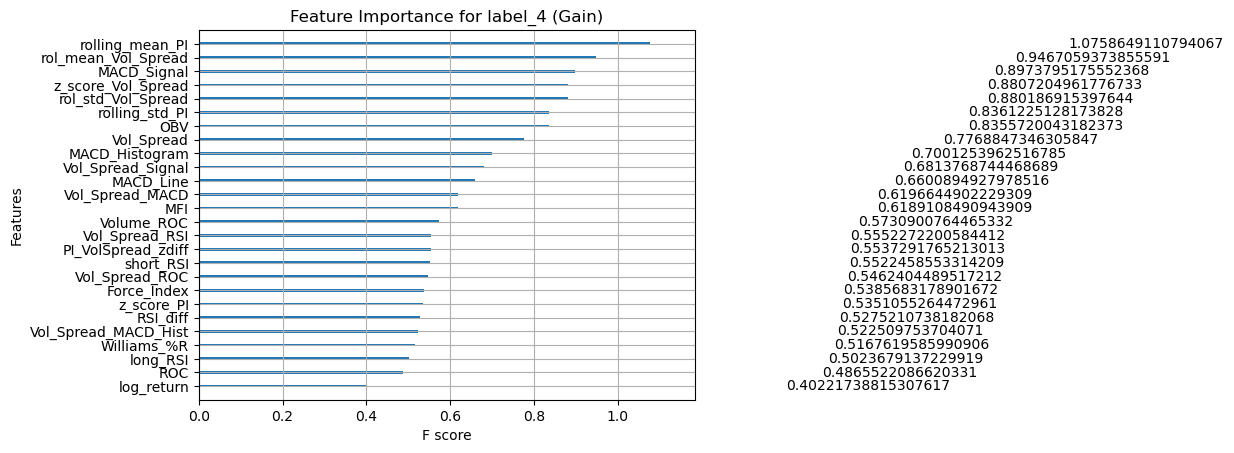

<Figure size 1600x1400 with 0 Axes>

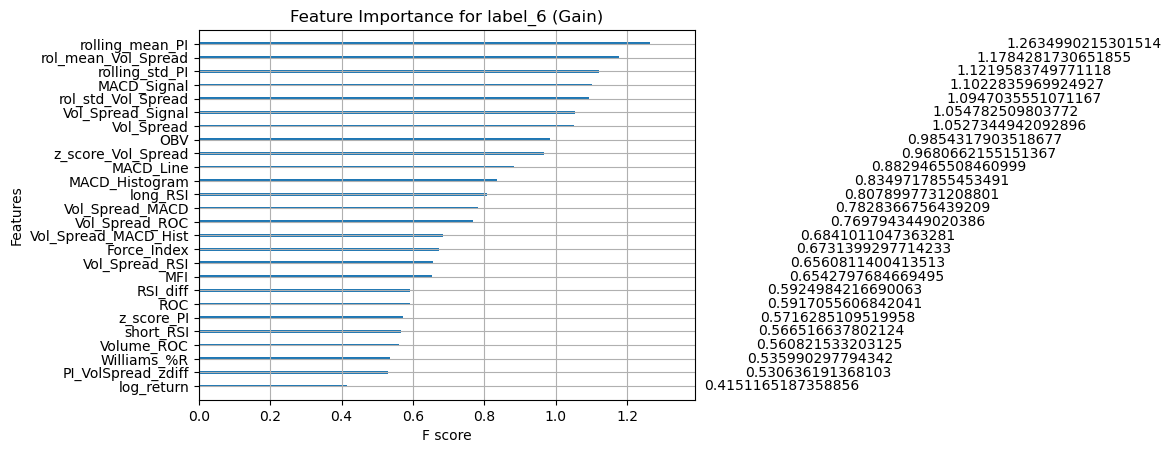

<Figure size 1600x1400 with 0 Axes>

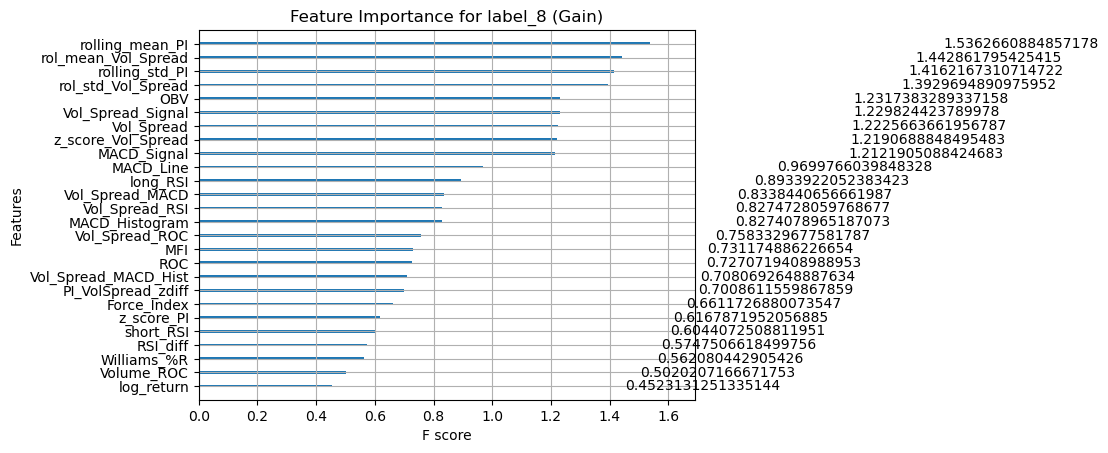

<Figure size 1600x1400 with 0 Axes>

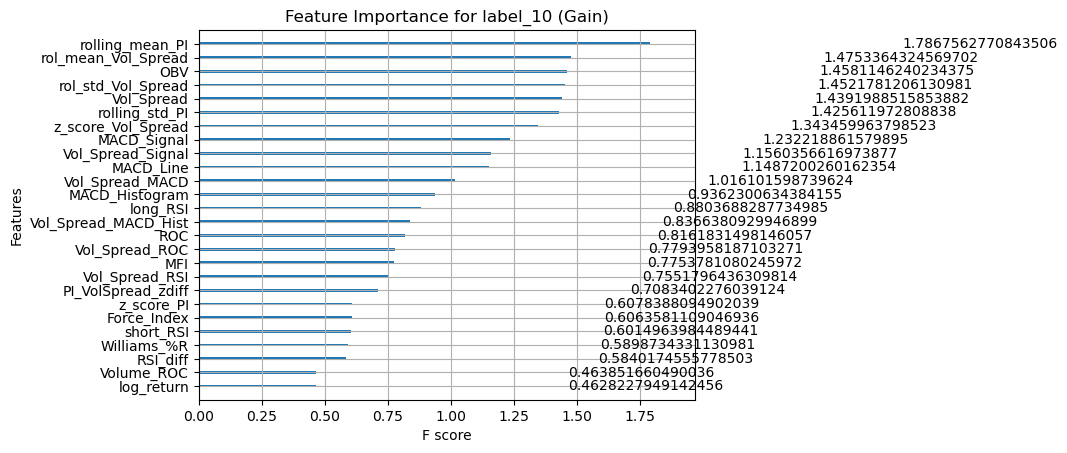

<Figure size 1600x1400 with 0 Axes>

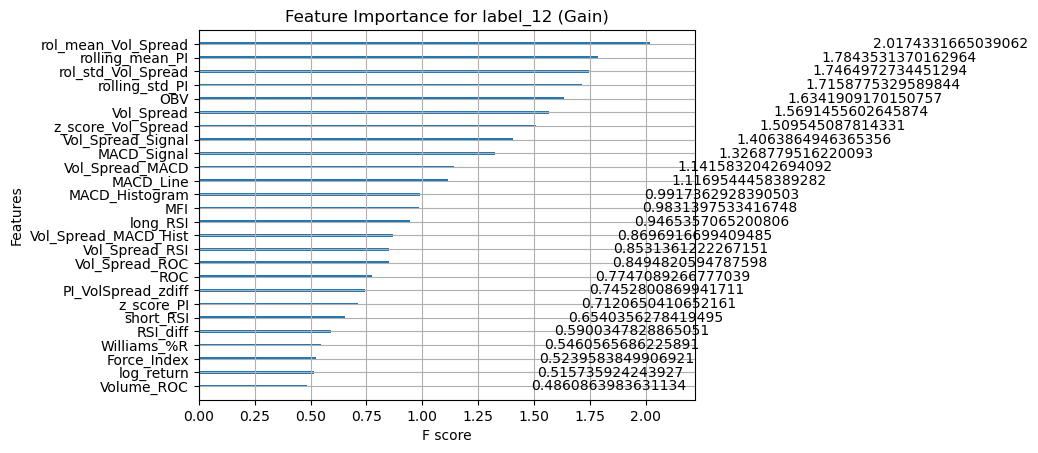

<Figure size 1600x1400 with 0 Axes>

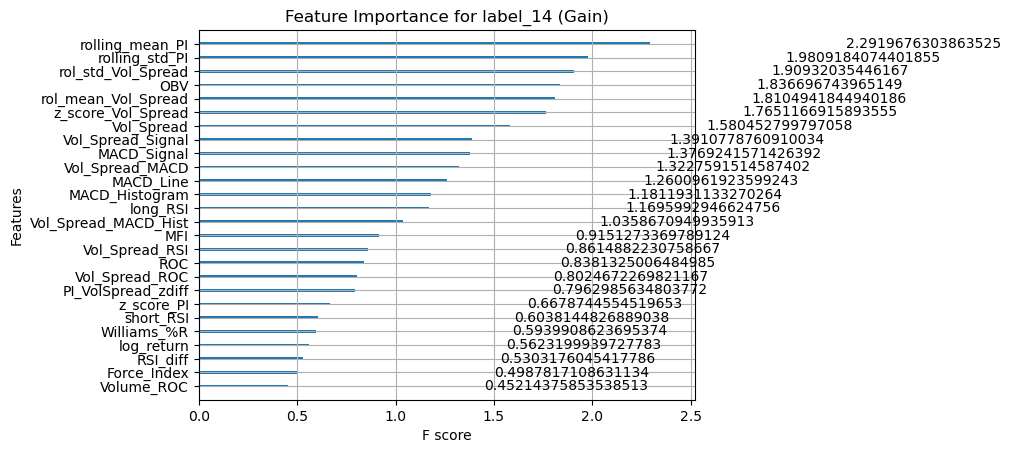

<Figure size 1600x1400 with 0 Axes>

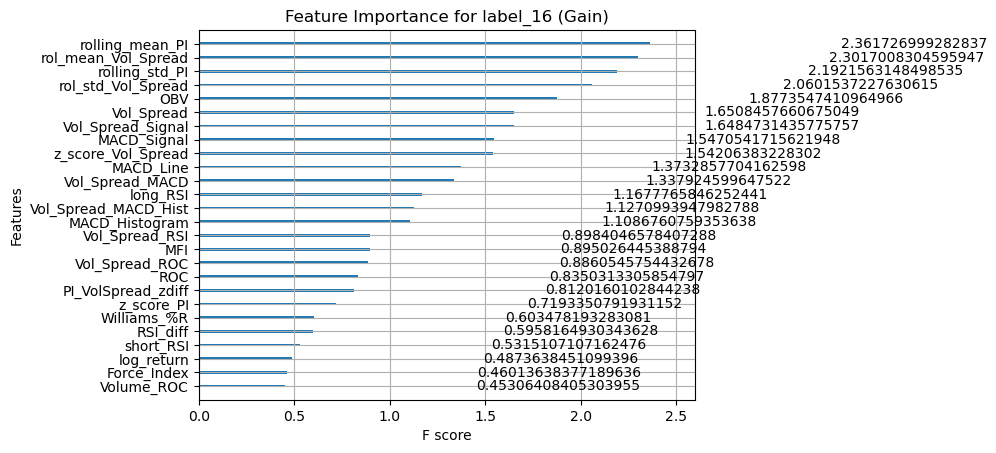

In [10]:
# Loop over each target label in the dictionary
for target, model_dict in models.items():
    # Get the XGBoost model for the current target
    xgb_model = model_dict['XGBoost']
    
    '''# Plot the first tree of the model
    plt.figure(figsize=(20, 10))
    xgb.plot_tree(xgb_model, num_trees=0)
    plt.title(f"XGBoost Tree for {target}")
    plt.show()'''
    
    # Plot feature importance (using 'gain' as the importance type)
    plt.figure(figsize=(16, 14
                       ))
    xgb.plot_importance(xgb_model, importance_type='gain')
    plt.title(f"Feature Importance for {target} (Gain)")
    plt.show()

In [11]:
#!pip install graphviz
